# The Street View House Numbers (SVHN) Dataset

- http://ufldl.stanford.edu/housenumbers/

## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import torchvision as tv

from lib.pytorch_trainer import (DeepNetTrainer, 
                                 ModelCheckpoint, 
                                 PrintCallback, 
                                 Callback)

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


In [2]:
train_trafo = tv.transforms.Compose([
    tv.transforms.RandomCrop(30),
    tv.transforms.ToTensor(),
])
valid_trafo = tv.transforms.Compose([
    tv.transforms.CenterCrop(30),
    tv.transforms.ToTensor(),
])

train_ds = tv.datasets.SVHN('/data/datasets/Google_SVHN_2/', split='train', 
                            transform=train_trafo, 
                            # the original dataset has targets from 1 to 10; convert to 0~9
                            target_transform=lambda x: x.astype(np.int)[0] % 10)

valid_ds = tv.datasets.SVHN('/data/datasets/Google_SVHN_2/', split='test', 
                            transform=valid_trafo, 
                            # the original dataset has targets from 1 to 10; convert to 0~9
                            target_transform=lambda x: x.astype(np.int)[0] % 10)

In [3]:
if 1:
    # reduz quantidade de dados para testes iniciais
    valid_ds.data = valid_ds.data[:3000]
    train_ds.data = train_ds.data[:5000]
    valid_ds.labels = valid_ds.labels[:3000]
    train_ds.labels = train_ds.labels[:5000]

4 torch.Size([3, 30, 30])


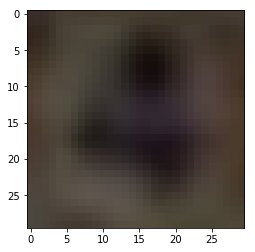

In [4]:
ii = np.random.randint(len(train_ds))
image, label = train_ds[ii]
print(label, image.shape)
plt.imshow(image.numpy().transpose(1, 2, 0));

In [5]:
batch_size = 20
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [6]:
class MyPlotCallback(Callback):
    def __init__(self, interval=1):
        self.interval = interval
    
    def on_train_begin(self, n_epochs):
        self.val = self.trainer.has_validation
        self.line_train = None
        self.line_valid = None
        
        self.fig = plt.figure(figsize=(15,6))
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.ax.grid(True)
        self.plot_losses(self.trainer.metrics['train']['losses'], 
                         self.trainer.metrics['valid']['losses'])
    
    def on_epoch_end(self, epoch, metrics):
        if epoch % self.interval == 0:
            if self.val:
                best_epoch = int(np.argmin(self.trainer.metrics['valid']['losses'])) + 1
            else:
                best_epoch = int(np.argmin(self.trainer.metrics['train']['losses'])) + 1
        
            self.plot_losses(trainer.metrics['train']['losses'],
                             trainer.metrics['valid']['losses'], best_epoch==epoch)
            
        display.clear_output(wait=True)

            
    def plot_losses(self, htrain, hvalid, best_epoch=0):
        if self.line_train: self.line_train.remove()
        if self.line_valid: self.line_valid.remove()
        
        x = np.arange(1, len(htrain) + 1)
        self.line_train, = self.ax.plot(x, htrain, color='#1f77b4', linewidth=2, label='training loss')
        self.line_valid, = self.ax.plot(x, hvalid, color='#ff7f0e', linewidth=2, label='validation loss')
        self.ax.legend()
                
        if best_epoch:
            self.ax.vlines(best_epoch, *(self.ax.get_ylim()), colors='#EBDDE2', linestyles='dashed')

        display.display(self.fig)
        time.sleep(0.1)

    def plot_losses_2(self, htrain, hvalid, best_epoch=0):
        if self.line_train is None:
            line_train = plt.plot(htrain, linewidth=2, label='training loss')
            if hvalid[0]:
                line_valid = plt.plot(hvalid, linewidth=2, label='validation loss')
        else:
            self.line_train.set_xdata(np.arange(htrain.shape[0]))
            self.line_train.set_ydata(htrain)
            if hvalid[0]:
                self.line_valid.set_xdata(np.arange(hvalid.shape[0]))
                self.line_valid.set_ydata(hvalid)
                
        if best_epoch:
            plt.vlines(best_epoch, 0, 100, colors='#EBDDE2', linestyles='dashed')
            
        plt.legend()
        
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [7]:
def compute_accuracy(logits, labels):
    _, preds = torch.max(logits.data, 1)
    return (preds == labels.data).type(torch.FloatTensor).mean()

In [8]:
class MyNet(nn.Module):
    # Input size is (-1, 3, 30, 30)
    def __init__(self):
        super(MyNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [9]:
trainIt = True
resetIt = False

# Callbacks
# ---------
chkpt_cb = ModelCheckpoint('../../models/svhn_01XX', reset=resetIt, verbose=1)
print_cb = PrintCallback()
plot_cb = MyPlotCallback()

# Model, optimizer and learning rate scheduler
# --------------------------------------------
model = MyNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

# Network trainer
# ---------------
training_parameters = {
    'model':         model, 
    'criterion':     nn.CrossEntropyLoss(),
    'metrics':       dict(acc=compute_accuracy), 
    'optimizer':     optimizer, 
    'lr_scheduler':  scheduler, 
    'callbacks':     [chkpt_cb, print_cb, plot_cb],
}
trainer = DeepNetTrainer(**training_parameters)


Best model was saved at epoch 41 with loss 1.72489: ../../models/svhn_01XX
Stop training at epoch: 42/42


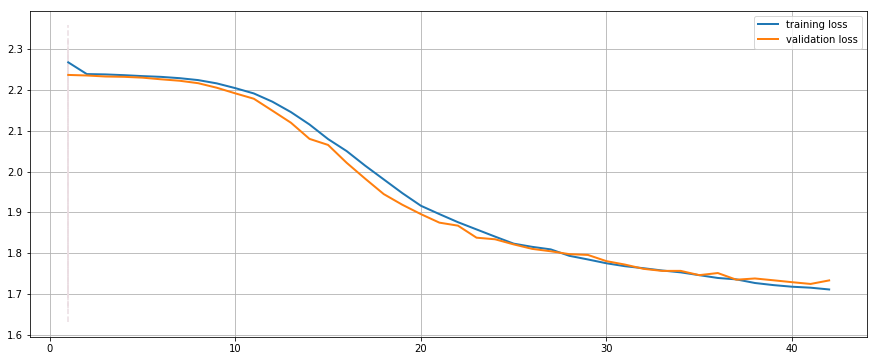

In [12]:
if trainIt:
    trainer.fit(5, train_dl, valid_dl)
else:
    print('\nTraining disabled.\nThis model was trained for {} epochs.'.format(trainer.last_epoch))

In [11]:
metrics = trainer.evaluate_loader(train_dl)
print('Model training set accuracy after training: {:.5f}'.format(metrics['acc']))
print()
metrics = trainer.evaluate_loader(valid_dl)
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

evaluate: 249/249 ok
Model training set accuracy after training: 0.38760

evaluate: 149/149 ok
Model validation set accuracy after training: 0.38933
